In [1]:
import pandas as pd
import numpy as np
from sklearn import neighbors, datasets
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Read in the .csv file
near_earth_objects = pd.read_csv("data/neo_v2.csv")
near_earth_objects.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


## Getting the data ready/Data cleaning: 
I am going to use the nearest neighbors technique to train a model. The data cleaning protocol includes the following two tasks:
1. Removing the non-numerical columns from the data. 
2. Changing the True/False to 1/0 (True is 1 and False is 0).

In [3]:
# (1) There is only one numerical column here:
# nn_columns = ["orbiting_body", "sentry_object"]
clean_data = near_earth_objects.drop(["orbiting_body", "sentry_object", "id", "name"], axis=1)
# (2) Changing sentry_object and hazardous from True/False to 1/0
bool_columns = ["hazardous"]
clean_data[bool_columns] = clean_data[bool_columns].astype(int)

In [4]:
clean_data.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


In [5]:
clean_data.isnull().sum()
# There are no null values to take care of, so the data is ready to machinelearningize

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

## Dimensionality reduction and Normalization

Some of the features might be correlated. This will make the feature space not orthogonal. That is a no no. I need to figure out how to eliminate correlated features. My feature space will become smaller. Also, need to normalize the data frame for nice predictions.

<AxesSubplot:>

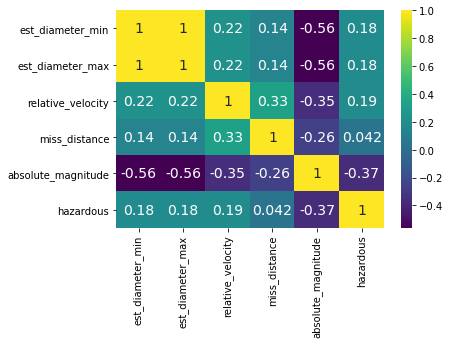

In [6]:
correlation_matrix = clean_data.corr()
sn.heatmap(correlation_matrix, annot= True,  annot_kws = {'size':14}, cmap = "viridis")

In [7]:
# I can see clearly that diameter_min and diameter_max are highly correlated. I only need to use one of them. 
# I am going to choose diameter max because it feels more hype. 
clean_data = clean_data.drop(["est_diameter_min"], axis=1)

<AxesSubplot:>

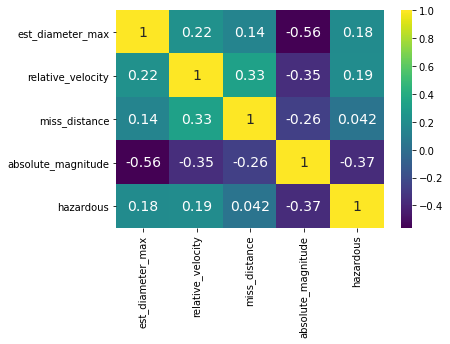

In [8]:
correlation_matrix = clean_data.corr()
sn.heatmap(correlation_matrix, annot= True,  annot_kws = {'size':14}, cmap = "viridis")
# now the highest correlation is -0.56, I think it is not too bad, this may prove to be a better multivariate model. 

In [9]:
# normalization of the clean_data data frame:
target_column = clean_data["hazardous"]
clean_data = (clean_data-clean_data.min())/(clean_data.max()-clean_data.min())
clean_data["hazardous"] = target_column

In [10]:
clean_data.head()

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.031607,0.056447,0.733141,0.312891,0
1,0.006999,0.309922,0.821364,0.449312,1
2,0.019039,0.481680,0.665740,0.358782,0
3,0.002531,0.103726,0.339986,0.541093,0
4,0.006714,0.179632,0.618634,0.453066,1


## The imbalance of the two classes:

I believe that there is another problem with the data set. The negative class has much more values than the positive class. The two classes need to be roughly the same amount of instances for the classification model to work well.

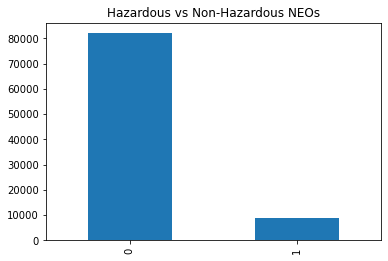

In [13]:
clean_data.hazardous.value_counts().plot(kind='bar')
plt.title('Hazardous vs Non-Hazardous NEOs')
plt.show()

# We can see from this plot that the Near Earth Objects that are hazardous are a little below 10000. 
# Would it be beneficial to only use around 10000 values for the negative class as well. 

In [14]:
# Only 10.78 percent of the values are True, everything else is False. These values need to be close to 50-50

clean_data["hazardous"].value_counts()

0    81996
1     8840
Name: hazardous, dtype: int64

In [15]:
# down-sampling the majority class:
from sklearn.utils import resample

# Separate majority and minority classes
hazardous_majority = clean_data[clean_data.hazardous==0]
hazardous_minority = clean_data[clean_data.hazardous==1]
 
# Downsample majority class
majority_downsampled = resample(hazardous_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=8840) # to match the minority class
 
# Combine minority class with downsampled majority class
downsampled = pd.concat([majority_downsampled, hazardous_minority])
 
# Display new class counts
downsampled.hazardous.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

1    8840
0    8840
Name: hazardous, dtype: int64

## Univariate Model for classification

This model takes in one feature and based on that feature it predicts the target values. Therefore, it is called a univariate model. The purpose of this model is to separate the effectiveness of the features and sort them.

In [16]:
from sklearn.model_selection import train_test_split

def knn_univariate_classification(feature, target, df):
    """
    This function makes prediction based on just one feature.
    Params: The feature column, the target column, and the data frame. 
    Returns: The predictions.
    """
    k_neighbors = 15
    
    # train, test, and split the model:
    train, test = train_test_split(df, test_size=0.3)
    
    # fit the knn model to make predictions:
    knn = neighbors.KNeighborsClassifier(k_neighbors)
    knn.fit(train[[feature]], train[target])
    
    # make the predictions:
    predictions = knn.predict(test[[feature]])
    
    return [predictions, test[target]]

## Multivariate Model:

In [17]:
def knn_multivariate_classification(features, target, df):
    """
    This function can make predictions based on any and all the features.
    Params: A features array, a target, and a data frame.
    Returns: the predictions.
    """
    
    k_neighbors = 15
    
    # train, test, split the model:
    train, test = train_test_split(df, test_size=0.3)
    
    # fit the model to make predictions:
    knn = neighbors.KNeighborsClassifier(k_neighbors)
    knn.fit(train.loc[:, features], train[target])
    
    # make predictions:
    predictions = knn.predict(test.loc[:, features])
    
    return [predictions, test[target]]

## Analyzation of the results:
1. Confusion matrix: Form the confusion matrix, I want to use the f1 score to rank the performance of the features. 

f1 score:  0.5319465081723626


<AxesSubplot:>

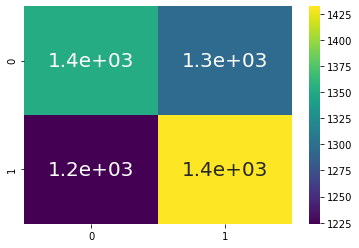

In [19]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# For a confusion matrix; confusion_matrix(true, pred). Running the Knn univariate on your choosing of the 
# feature.

uni_results = knn_univariate_classification("miss_distance", "hazardous", downsampled)

# print out the confusion_matrix and the f1 score for this particular feature. 
conf_mat = confusion_matrix(uni_results[1], uni_results[0])
f1_score_u = f1_score(uni_results[1], uni_results[0])

print("f1 score: ", f1_score_u)
sn.heatmap(conf_mat, annot = True, annot_kws = {'size':20} ,cmap = "viridis")

The f1 score:  0.8873287671232877


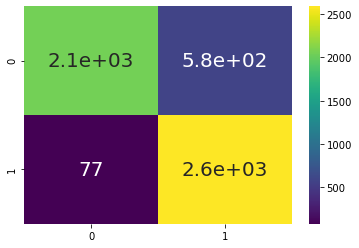

In [20]:
from sklearn.metrics import f1_score
mul_results = knn_multivariate_classification(["est_diameter_max", "absolute_magnitude"], "hazardous", downsampled)

# print out the confusion_matrix and f1 score for the three best features:
conf_mat = confusion_matrix(mul_results[1], mul_results[0])
sn.heatmap(conf_mat, annot = True, annot_kws = {'size':20} ,cmap = "viridis")

f1_score_m = f1_score(mul_results[1], mul_results[0])
print("The f1 score: ", f1_score_m)

# To-do list:
1. Calculate the Precesion, Recall, and f1 score for all the variables remaining.
2. Learn the workings or ROC curve and use it for unbalanced classes predictions.
3. Read papers about NEOs, try to understand how their physics works. 